# Day 6: Locality Sensitive Hashing for Trading

## 🎯 Learning Objectives
- Understand LSH for approximate nearest neighbors
- Scale similarity search for large datasets
- Apply to regime detection and pattern matching

---

## 📚 Theory: LSH

### The Problem
Exact kNN is O(n) per query - too slow for large datasets.

### LSH Solution
Hash similar items to same bucket with high probability.

$$P(h(x) = h(y)) = f(sim(x, y))$$

### Types
- MinHash for Jaccard similarity
- Random Projections for cosine similarity
- p-stable distributions for Euclidean distance

---

In [8]:
import numpy as np
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import warnings
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.random_projection import GaussianRandomProjection
from sklearn.metrics import accuracy_score
import time

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-whitegrid')

TRADING_DAYS = 252
RISK_FREE_RATE = 0.05

# Download data
ticker = 'SPY'
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print("📥 Downloading data...")
data = yf.download(ticker, start=start_date, end=end_date, progress=False, auto_adjust=True)
prices = data['Close']
returns = prices.pct_change().dropna()

print(f"✅ Data: {len(prices)} days")

📥 Downloading data...
✅ Data: 1254 days


In [9]:
# Create features
df = pd.DataFrame(index=prices.index)
df['return'] = returns

for lag in [1, 5, 10, 20]:
    df[f'momentum_{lag}'] = prices.pct_change(lag)

for window in [5, 10, 20]:
    df[f'volatility_{window}'] = returns.rolling(window).std()

df['ma_ratio'] = prices / prices.rolling(20).mean() - 1

df['next_return'] = returns.shift(-1)
df['target'] = (df['next_return'] > 0).astype(int)

df = df.dropna()
feature_cols = [c for c in df.columns if c not in ['return', 'next_return', 'target']]

print(f"📊 Features: {len(feature_cols)}, Samples: {len(df)}")

📊 Features: 8, Samples: 1233


In [10]:
# Prepare data
X = df[feature_cols].values
y = df['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

split_idx = int(len(df) * 0.8)
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]
returns_test = df['next_return'].iloc[split_idx:]

print(f"Train: {len(X_train)}, Test: {len(X_test)}")

Train: 986, Test: 247


In [11]:
# Simple LSH using Random Projections
class SimpleLSH:
    def __init__(self, n_components=4, n_tables=5):
        self.n_components = n_components
        self.n_tables = n_tables
        self.projections = []
        self.tables = []
        
    def fit(self, X, y):
        n_features = X.shape[1]
        self.X_train = X
        self.y_train = y
        
        for _ in range(self.n_tables):
            # Random projection matrix
            proj = np.random.randn(n_features, self.n_components)
            self.projections.append(proj)
            
            # Hash training data
            hashes = self._hash(X, proj)
            
            # Build hash table
            table = {}
            for i, h in enumerate(hashes):
                h_tuple = tuple(h)
                if h_tuple not in table:
                    table[h_tuple] = []
                table[h_tuple].append(i)
            self.tables.append(table)
        
        return self
    
    def _hash(self, X, proj):
        projected = X @ proj
        return (projected > 0).astype(int)
    
    def predict(self, X, k=10):
        predictions = []
        
        for x in X:
            candidates = set()
            
            # Find candidates from all tables
            for proj, table in zip(self.projections, self.tables):
                h = tuple(self._hash(x.reshape(1, -1), proj)[0])
                if h in table:
                    candidates.update(table[h])
            
            if len(candidates) == 0:
                # No candidates, use random
                predictions.append(np.random.choice([0, 1]))
                continue
            
            # Find actual k nearest among candidates
            candidates = list(candidates)
            distances = np.linalg.norm(self.X_train[candidates] - x, axis=1)
            k_actual = min(k, len(candidates))
            nearest = np.argsort(distances)[:k_actual]
            nearest_labels = self.y_train[np.array(candidates)[nearest]]
            
            # Majority vote
            pred = int(np.mean(nearest_labels) > 0.5)
            predictions.append(pred)
        
        return np.array(predictions)

# Train LSH
print("\n⏳ Training LSH...")
lsh = SimpleLSH(n_components=4, n_tables=10)
lsh.fit(X_train, y_train)

# Compare speed
start = time.time()
y_pred_lsh = lsh.predict(X_test, k=10)
lsh_time = time.time() - start

start = time.time()
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_test)
knn_time = time.time() - start

print(f"\n" + "="*60)
print("LSH vs EXACT KNN")
print("="*60)
print(f"\n{'Method':<15} {'Accuracy':>12} {'Time':>12}")
print("-" * 40)
print(f"{'LSH':<15} {accuracy_score(y_test, y_pred_lsh):>12.2%} {lsh_time:>12.4f}s")
print(f"{'Exact kNN':<15} {accuracy_score(y_test, y_pred_knn):>12.2%} {knn_time:>12.4f}s")


⏳ Training LSH...

LSH vs EXACT KNN

Method              Accuracy         Time
----------------------------------------
LSH                   42.51%       0.0344s
Exact kNN             43.32%       0.0457s


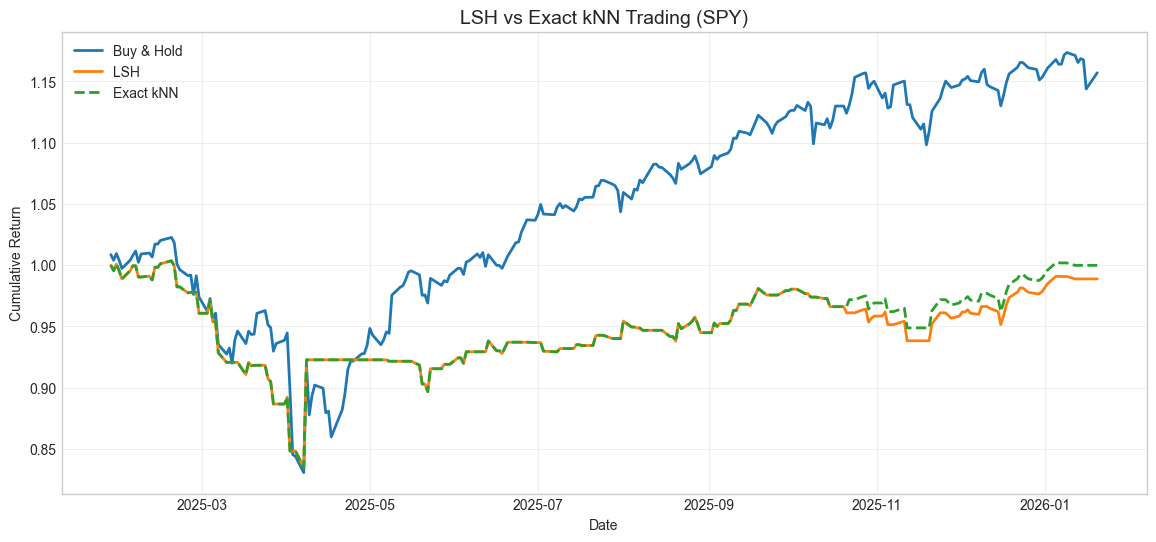

In [12]:
# Trading backtest
backtest = pd.DataFrame(index=df.index[split_idx:])
backtest['actual_return'] = returns_test.values
backtest['lsh_signal'] = y_pred_lsh
backtest['knn_signal'] = y_pred_knn

backtest['lsh_return'] = backtest['lsh_signal'] * backtest['actual_return']
backtest['knn_return'] = backtest['knn_signal'] * backtest['actual_return']

backtest['buy_hold_cum'] = (1 + backtest['actual_return']).cumprod()
backtest['lsh_cum'] = (1 + backtest['lsh_return']).cumprod()
backtest['knn_cum'] = (1 + backtest['knn_return']).cumprod()

# Plot
plt.figure(figsize=(14, 6))
plt.plot(backtest.index, backtest['buy_hold_cum'], label='Buy & Hold', linewidth=2)
plt.plot(backtest.index, backtest['lsh_cum'], label='LSH', linewidth=2)
plt.plot(backtest.index, backtest['knn_cum'], label='Exact kNN', linewidth=2, linestyle='--')
plt.title(f'LSH vs Exact kNN Trading ({ticker})', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [13]:
# Performance
def calc_metrics(returns, cumulative):
    total = cumulative.iloc[-1] - 1
    sharpe = (returns.mean() * TRADING_DAYS - RISK_FREE_RATE) / (returns.std() * np.sqrt(TRADING_DAYS)) if returns.std() > 0 else 0
    peak = cumulative.cummax()
    mdd = ((cumulative - peak) / peak).min()
    return total, sharpe, mdd

print("\n" + "="*60)
print("STRATEGY PERFORMANCE")
print("="*60)

strategies = [
    ('Buy & Hold', 'actual_return', 'buy_hold_cum'),
    ('LSH', 'lsh_return', 'lsh_cum'),
    ('Exact kNN', 'knn_return', 'knn_cum')
]

print(f"\n{'Strategy':<15} {'Total Ret':>12} {'Sharpe':>10} {'Max DD':>10}")
print("-" * 50)

for name, ret_col, cum_col in strategies:
    total, sharpe, mdd = calc_metrics(backtest[ret_col], backtest[cum_col])
    print(f"{name:<15} {total:>12.2%} {sharpe:>10.2f} {mdd:>10.2%}")


STRATEGY PERFORMANCE

Strategy           Total Ret     Sharpe     Max DD
--------------------------------------------------
Buy & Hold            15.70%       0.60    -18.76%
LSH                   -1.12%      -0.35    -16.79%
Exact kNN             -0.01%      -0.27    -16.79%


In [14]:
# Next day prediction
latest_scaled = scaler.transform(df[feature_cols].iloc[[-1]])
pred_lsh = lsh.predict(latest_scaled, k=10)[0]
pred_knn = knn.predict(latest_scaled)[0]
proba_knn = knn.predict_proba(latest_scaled)[0]

print("\n" + "="*60)
print(f"📊 NEXT DAY PREDICTION FOR {ticker}")
print("="*60)
print(f"\nDate: {df.index[-1].strftime('%Y-%m-%d')}")
print(f"\nLSH Prediction: {'📈 UP' if pred_lsh == 1 else '📉 DOWN'}")
print(f"kNN Prediction: {'📈 UP' if pred_knn == 1 else '📉 DOWN'}")
print(f"kNN Probability: {proba_knn[1]:.1%}")
print(f"\n🎯 Consensus: {'BULLISH' if pred_lsh + pred_knn == 2 else 'BEARISH' if pred_lsh + pred_knn == 0 else 'MIXED'}")


📊 NEXT DAY PREDICTION FOR SPY

Date: 2026-01-20

LSH Prediction: 📉 DOWN
kNN Prediction: 📉 DOWN
kNN Probability: 50.0%

🎯 Consensus: BEARISH


---

## 🏢 Real-World Applications

| Company | LSH Use Case |
|---------|-------------|
| Google | Duplicate detection |
| HFT Firms | Real-time similarity search |
| Quant Funds | Large-scale pattern matching |

### Key Interview Points
1. **Why LSH?** - Sub-linear query time for large datasets
2. **Trade-offs?** - Speed vs accuracy
3. **When exact?** - Small datasets or high precision needed

---
## 📅 Tomorrow: Week 8 Interview Review